# Instance Weighting Transfer Learning ULSA -> UENG
# Model 1

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.base import clone
from scipy.stats import bootstrap
from scipy.stats import kstest

In [2]:
from cvxopt import matrix
from cvxopt import solvers

In [3]:
from transformers.features_missing_vals import imputation_pipeline
from transformers.ethnic_groups import CombineEthnicGroups

In [4]:
# CVXOPT
from transfer_learning.cvxopt_input import get_cvxopt_input
from transfer_learning.transfer_learning import transfer_learning
from transfer_learning.length_scale import calc_kernels_for_l

In [6]:
from model_evaluation.metrics import calc_y_mean
from model_evaluation.metrics import plot_roc_curves
from model_evaluation.metrics import KS_test_comparison, plot_KS_CDF
from model_evaluation.metrics import plot_dropout_rate, plot_dropout_rate_two_models
from model_evaluation.metrics import gen_entropy_comparison
from fairness.fairness_metrics import sliced_auc, fairn_metrics
from fairness.customized_entropy import calc_educ_benefits
from fairness.customized_entropy import calc_educ_rank_benefits
from fairness.customized_entropy import gen_entropy_index

# Params

In [7]:
source_school = 'ULSA'
target_school = 'UENG'

In [8]:
# Model features
cols = ['STDNT_FEMALE',
        'HS_GPA_BIN',
        'CURR_GPA',
        'HS_CALC_IND',
        'SNGL_PRNT_IND',
        'STDNT_ASIAN_IND',
        'STDNT_BLACK_IND',
        'STDNT_HSPNC_IND',
        'STDNT_NTV_AMRCN_HWIAN_IND',
        'STDNT_MULTI_ETHNC_IND',
        'STDNT_ETHNC_NAN',
        'SAT_ACT_TOTAL_BIN',
        'ACAD_LOAD',
        'No_grades_at_all',
        'Grade_Overall_I_for_1_and_more_courses',
        'Grade_W_for_1_course',
        'Grade_W_for_2_courses',
        'Grade_W_for_3_and_more_courses',
        'Grade_NR_for_1_and_more_courses']

In [9]:
random_state = 1

In [10]:
clf = LogisticRegression(penalty=None, random_state=random_state, max_iter=10000)

In [11]:
# Parameters for fairness metrics

# Priviledged values of attributes
attribites_dic = {
    'STDNT_ETHNC_grouped': 0, # white
    'STDNT_FEMALE': 0 # male
    }

# The threshold for intervention is based on the percentile of predicted dropout probabilities, 
# specifically targeting the top 10% of students with the highest dropout probabilities
threshold=[10]

# Percentile values of predicted dropout probabilities that determine the risk ranking of a student
rank_thresholds = [90, 95, 97, 99, 99.5]

# Data

In [12]:
features_df = pd.read_csv('features_df.csv', low_memory=False)
source_df = features_df[features_df['PRMRY_CRER_CD']==source_school].copy()
target_df = features_df[features_df['PRMRY_CRER_CD']==target_school].copy()

In [ ]:
# Group together all ethnic groups, excluding white and asian populations, as they lack a sufficient 
# number of dropouts for a meaningful fairness analysis

# Add new column 'STDNT_ETHNC_grouped' with the following values: 0 for white, 1 for asian, and 2 for other
combine_transformer = CombineEthnicGroups()
target_df = combine_transformer.fit_transform(target_df)

target_df.groupby('STDNT_ETHNC_grouped')[['y_ENROLLED_1_YEAR_LATER']].agg(['count', 'sum'])

In [14]:
# Imputation of missing values and applying WoE transformation
source_df = combine_transformer.fit_transform(source_df)
source_imp = imputation_pipeline.fit_transform(source_df, source_df['y_ENROLLED_1_YEAR_LATER'])
target_imp = imputation_pipeline.transform(target_df)

In [15]:
scaler = StandardScaler()
scaler.fit(source_imp[cols])

StandardScaler()

In [16]:
X_source = scaler.transform(source_imp[cols])
X_target = scaler.transform(target_imp[cols])

## Data distribution for protected attributes

In [ ]:
# Female
target_df.groupby('STDNT_FEMALE')[['y_ENROLLED_1_YEAR_LATER']].agg(['count', 'sum'])

In [ ]:
# International students
target_df.groupby('STDNT_INTL_IND')[['y_ENROLLED_1_YEAR_LATER']].agg(['count', 'sum'])

In [ ]:
# Race
dic = {1: 'White', 2: 'Black', 3: 'Hispanic', 
       4: 'Asian', 5: 'Native Amr', 6: 'Not Indic', 
       7: 'Hawaiian', 0: '2 or More'}
target_df.groupby('STDNT_ETHNC_GRP_CD')[['y_ENROLLED_1_YEAR_LATER']].agg(['count', 'sum'])

# Direct transfer

## Fitting the source model

In [20]:
clf_source = clone(clf)

y = source_imp['y_ENROLLED_1_YEAR_LATER']

clf_source.fit(X_source, y)

y_pred = clf_source.predict_proba(X_source)
auc_source_train = roc_auc_score(y, y_pred[:,1])
auc_source_train

0.7933412954905419

## Direct source model transfer (without weighting)

In [21]:
y_pred = clf_source.predict_proba(X_target)

In [22]:
# DataFrame containing true and predicted y
df_true_predict = pd.DataFrame(data={'y': target_imp['y_ENROLLED_1_YEAR_LATER'], 'y_pred': y_pred[:,1]})

## Classification accuracy

### AUC ROC

In [23]:
auc_direct = roc_auc_score(df_true_predict['y'], df_true_predict['y_pred'])
auc_direct

0.7808228185103911

In [24]:
# ROC curve
fpr, tpr, thresholds = roc_curve(df_true_predict['y'], df_true_predict['y_pred'], pos_label=1)

### Pietra Index and Kolmogorov-Smirnov test

In [25]:
ks_test_direct = kstest(df_true_predict.loc[df_true_predict['y']==0, 'y_pred'], 
                        df_true_predict.loc[df_true_predict['y']==1, 'y_pred'])
ks_test_direct

KstestResult(statistic=0.47627388021169487, pvalue=1.249983399554659e-26, statistic_location=0.012838414990417582, statistic_sign=1)

### Realized probability of dropout

In [26]:
percent_list = [0, 20, 40, 60, 80, 90, 95, 97, 99, 99.5, 100]
names_list = ['0-\n20', '20-\n40', '40-\n60', '60-\n80', '80-\n90', '90-\n95', '95-\n97', '97-\n99', '99-\n99.5', '99.5-\n100']

In [ ]:
plot_dropout_rate(
    df_true_predict, percent_list, names_list,
    'Observed probabilty of dropout for students grouped by\ntheir predicted probability of dropout (Direct transfer)'
)

### AUC Confidence Interval

In [28]:
def calc_auc(y, y_pred):
    auc = roc_auc_score(y, y_pred)
    return auc

In [29]:
bootstrap_res = bootstrap((df_true_predict['y'], df_true_predict['y_pred']), 
                          calc_auc, paired=True, n_resamples=10000,
                          method='BCa', confidence_level=0.95, random_state=random_state)

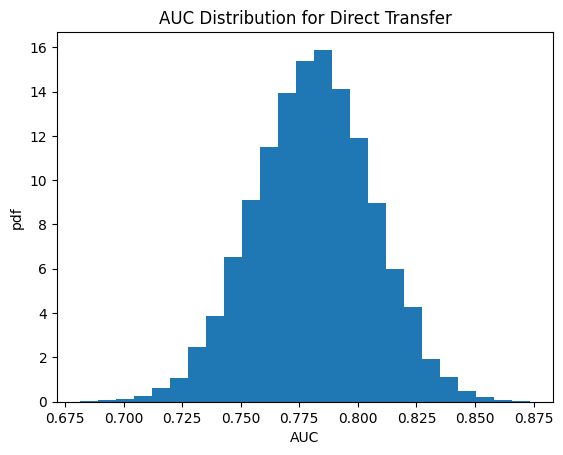

In [30]:
plt.hist(bootstrap_res.bootstrap_distribution, bins=25, density=True)
plt.title('AUC Distribution for Direct Transfer')
plt.xlabel('AUC')
plt.ylabel('pdf');

In [31]:
auc_conf_int = bootstrap_res.confidence_interval
auc_conf_int

ConfidenceInterval(low=0.7288679358548573, high=0.8268808205429621)

In [32]:
# Length of confidence interval
auc_conf_int[1] - auc_conf_int[0]

0.09801288468810476

## Fairness

### Sliced AUC

In [33]:
sliced_auc_direct = sliced_auc(df_true_predict['y'], 
                               df_true_predict['y_pred'],
                               ['STDNT_ETHNC_grouped', 'STDNT_FEMALE'], 
                               target_df)
sliced_auc_direct

,Attribute,Value,AUC
0,STDNT_ETHNC_grouped,1,0.71599
1,STDNT_ETHNC_grouped,0,0.839475
2,STDNT_ETHNC_grouped,2,0.792427
3,STDNT_FEMALE,0,0.776758
4,STDNT_FEMALE,1,0.795667


### Equal opportunity difference

In [34]:
equal_opport_direct = fairn_metrics(df_true_predict['y'], 
                                    df_true_predict['y_pred'],
                                    attribites_dic, target_df, 
                                    threshold)

equal_opport_direct

,Attribute,Value,thresh_10%
0,STDNT_ETHNC_grouped,1,-0.326271
1,STDNT_ETHNC_grouped,0,0
2,STDNT_ETHNC_grouped,2,0.118173
3,STDNT_FEMALE,0,0
4,STDNT_FEMALE,1,0.031316


### Generalized entropy index

In [35]:
gen_entropy_direct = gen_entropy_index(2, df_true_predict, 
                                       target_df['STDNT_ETHNC_grouped'], 
                                       calc_educ_benefits,
                                       threshold[0])
gen_entropy_direct

(0.4477611940298507, 0.05103587593695251)

### Generalized entropy index that takes into account the risk ranks of students

In [36]:
gen_entropy_ranks_direct = gen_entropy_index(2, df_true_predict, 
                                             target_df['STDNT_ETHNC_grouped'], 
                                             calc_educ_rank_benefits, 
                                             rank_thresholds)
gen_entropy_ranks_direct

(0.5821152926712658, 0.046075968818731626)

# Instance weighting strategy

## Selecting the value for the "length_scale" hyperparameter
The choice of the RBF’s length scale value was made by analyzing kernel matrices across various length scale values, specifically [1, 1.5, 1.75, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 10, 22]. 

The kernel function, when used to two points, applies a
transformation to the distance between these two points. The length scale parameter defines the sensitivity of this kernel function. When the parameter is set too high, the kernel function transforms distances to values closer to 1. Conversely, when the
parameter is set too low, the kernel function transforms distances towards 0. We should choose length scale that generates kernel matrices with values distinguishable from one another. The kernel matrices should encompass a variety of values, not just those very close to 0 or 1. It’s worth noting that the most distinct separation between distances occurs when the median distance corresponds to a kernel value of 0.5, positioning the median distance at the midpoint of the possible kernel range (0-1). 

For our task, this optimal condition corresponds to a length scale value of 4, as indicated by information obtained from the kernel matrices (see below).

In [37]:
length_scale_list = [1, 1.5, 1.75, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 10, 22]
quantiles = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]

In [27]:
calc_kernels_for_l(X_source, X_source,
                   length_scale_list, quantiles)

,0.00,0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99,1.00
1.0,0.0,0.0,0.0,0.0,0.0,0.000037,0.007153,0.086294,0.416154,0.94498,1.0
1.5,0.0,0.0,0.0,0.0,0.000237,0.010731,0.111287,0.336592,0.677298,0.975162,1.0
1.75,0.0,0.0,0.0,0.000019,0.002173,0.035738,0.199264,0.44933,0.751061,0.981691,1.0
2.0,0.0,0.0,0.000002,0.000245,0.009145,0.078027,0.290821,0.541996,0.803181,0.985952,1.0
2.5,0.0,0.0,0.000239,0.004891,0.049562,0.19545,0.453649,0.675705,0.869122,0.990986,1.0
3.0,0.0,0.0,0.003057,0.024856,0.124123,0.321857,0.577579,0.761686,0.907183,0.993732,1.0
3.5,0.0,0.0,0.014207,0.066242,0.215902,0.434794,0.668124,0.818731,0.930934,0.995391,1.0
4.0,0.0,0.000004,0.038505,0.12515,0.309237,0.528519,0.734355,0.858023,0.94668,0.996469,1.0
4.5,0.0,0.000052,0.076275,0.193579,0.39561,0.604204,0.783519,0.886045,0.95763,0.997209,1.0
5.0,0.0,0.000339,0.124374,0.264457,0.471831,0.664904,0.820692,0.906649,0.96554,0.997739,1.0


In [28]:
calc_kernels_for_l(X_source, X_target,
                   length_scale_list, quantiles)

,0.00,0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99,1.00
1.0,0.0,0.0,0.0,0.0,0.0,0.000066,0.008105,0.097345,0.476447,0.950286,1.0
1.5,0.0,0.0,0.0,0.000001,0.000299,0.013825,0.117643,0.355109,0.719275,0.977592,1.0
1.75,0.0,0.0,0.0,0.000036,0.002574,0.043049,0.207563,0.467362,0.784986,0.983487,1.0
2.0,0.0,0.0,0.000003,0.000399,0.010411,0.089977,0.300049,0.558571,0.830813,0.987333,1.0
2.5,0.0,0.0,0.000279,0.006673,0.05385,0.214113,0.462811,0.688858,0.888142,0.991874,1.0
3.0,0.0,0.0,0.003403,0.030841,0.131485,0.342901,0.585654,0.771952,0.920924,0.99435,1.0
3.5,0.0,0.0,0.01537,0.077619,0.225239,0.455503,0.674975,0.826824,0.941273,0.995846,1.0
4.0,0.0,0.000004,0.040895,0.141297,0.319424,0.547687,0.740113,0.864509,0.95472,0.996818,1.0
4.5,0.0,0.000053,0.079992,0.213059,0.405872,0.621453,0.788369,0.891333,0.96405,0.997485,1.0
5.0,0.0,0.000346,0.129261,0.285815,0.481721,0.680238,0.824804,0.91103,0.970779,0.997962,1.0


## Estimation of the weighted model

### Estimating weights

Estimating weights by solving the quadratic programming problem specified in Huang J., Smola A.J., Gretton A., Borgwardt K.M., and Scholkopf B. (2006). Correcting sample selection bias by unlabeled data. In Proceedings of the 19th International Conference on Neural Information Processing Systems (NIPS’06). MIT Press, Cambridge, MA, USA, 601–608.

In [38]:
length_scale = 4

In [23]:
# Get input for CVXOPT
P, q, G, h = get_cvxopt_input(X_source, X_target, length_scale)

In [24]:
start_time = time.time()
sol = solvers.qp(P,q,G,h)
print(time.time() - start_time, "seconds")

     pcost       dcost       gap    pres   dres
 0: -2.5321e+08 -8.8718e+11  9e+11  3e-03  8e-14
 1: -8.9384e+07 -8.4734e+11  9e+11  3e-03  7e-14
 2: -8.3614e+07 -8.4656e+11  9e+11  3e-03  8e-14
 4: -3.6591e+07 -9.4707e+09  9e+09  3e-05  2e-14
 5: -1.4424e+08 -1.5663e+09  1e+09  1e-14  6e-14
 6: -2.0339e+08 -6.9518e+08  5e+08  3e-14  8e-14
 7: -2.1101e+08 -6.9805e+08  5e+08  2e-14  8e-14
 8: -2.4567e+08 -3.7210e+08  1e+08  7e-15  2e-15
 9: -2.5108e+08 -2.7969e+08  3e+07  7e-15  1e-15
10: -2.5191e+08 -2.7484e+08  2e+07  9e-16  1e-15
11: -2.5294e+08 -2.5823e+08  5e+06  3e-16  1e-15
12: -2.5308e+08 -2.5719e+08  4e+06  3e-15  1e-15
13: -2.5317e+08 -2.5433e+08  1e+06  6e-15  9e-16
14: -2.5319e+08 -2.5408e+08  9e+05  1e-15  8e-16
15: -2.5320e+08 -2.5353e+08  3e+05  2e-15  7e-16
16: -2.5320e+08 -2.5350e+08  3e+05  5e-15  6e-16
17: -2.5321e+08 -2.5330e+08  9e+04  3e-15  6e-16
18: -2.5321e+08 -2.5328e+08  8e+04  5e-16  5e-16
19: -2.5321e+08 -2.5323e+08  2e+04  3e-16  5e-16
20: -2.5321e+08 -2.53

In [25]:
weights = np.array(sol['x']).flatten()

## Fitting the weighted source model

In [184]:
clf_weighted = clone(clf)
clf_weighted.fit(X_source, y, weights)

LogisticRegression(max_iter=10000, penalty=None, random_state=1)

## Weighted source model transfer

In [248]:
y_pred = clf_weighted.predict_proba(X_target)

In [249]:
# DataFrame containing true and predicted y
df_true_predict_w = pd.DataFrame(data={'y': target_imp['y_ENROLLED_1_YEAR_LATER'], 'y_pred': y_pred[:,1]})

In [250]:
df_true_predict_w.to_csv('df_true_predict_IWS_model_1.csv')

In [38]:
df_true_predict_w = pd.read_csv('df_true_predict_IWS_model_1.csv', index_col=0)

## Classification accuracy

### AUC

In [39]:
auc_IWS = roc_auc_score(df_true_predict_w['y'], df_true_predict_w['y_pred'])
auc_IWS

0.7858360494384924

In [40]:
print(f"AUC direct transfer = {auc_direct:.3f}, AUC instance weighting strategy = {auc_IWS:.3f}")

AUC direct transfer = 0.781, AUC instance weighting strategy = 0.786


### Comparison of ROC curves

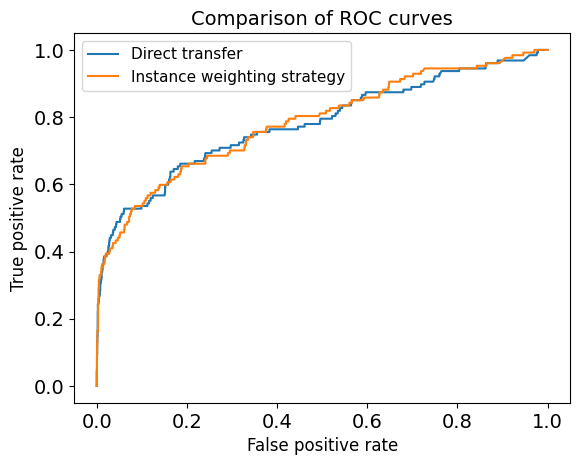

In [41]:
plot_roc_curves(df_true_predict, df_true_predict_w,
                'Direct transfer', 'Instance weighting strategy', 
                'Comparison of ROC curves')

### Pietra Index and Kolmogorov-Smirnov test

In [42]:
ks_test_IWS = kstest(df_true_predict_w.loc[df_true_predict_w['y']==0, 'y_pred'], 
                     df_true_predict_w.loc[df_true_predict_w['y']==1, 'y_pred'])

KS_test_comparison(ks_test_direct, ks_test_IWS)

,Pietra index,KS p_val
Direct tranfer,0.476274,1.249983e-26
Instance weighting strategy,0.465224,2.320641e-25


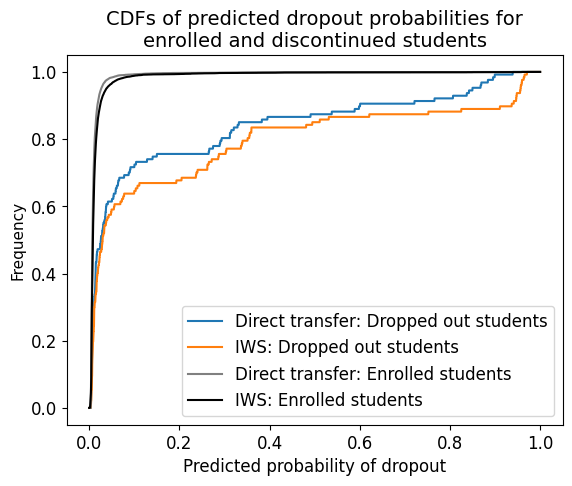

In [43]:
plot_KS_CDF(df_true_predict, df_true_predict_w)

### Realized probability of dropout

In [ ]:
plot_dropout_rate(
    df_true_predict_w, percent_list, names_list,
    'Observed probabilty of dropout for students grouped by\ntheir predicted probability of dropout (IWS)'
)

In [ ]:
plot_dropout_rate_two_models(df_true_predict, df_true_predict_w,
                             percent_list, names_list)

### AUC Confidence interval

In [46]:
bootstrap_res = bootstrap((df_true_predict_w['y'], df_true_predict_w['y_pred']), 
                          calc_auc, paired=True, n_resamples=10000,
                          method='BCa', confidence_level=0.95, random_state=random_state)

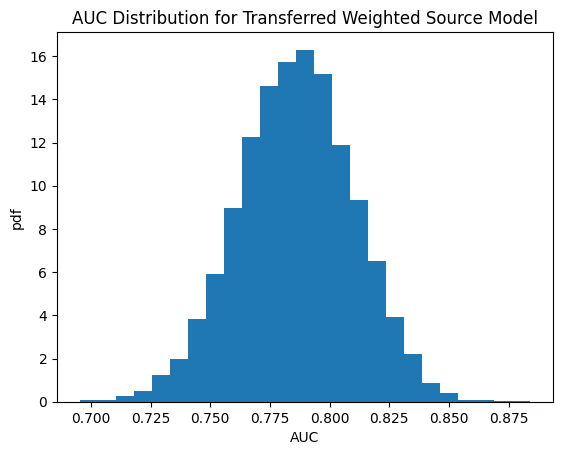

In [47]:
plt.hist(bootstrap_res.bootstrap_distribution, bins=25, density=True)
plt.title('AUC Distribution for Transferred Weighted Source Model')
plt.xlabel('AUC')
plt.ylabel('pdf');

In [48]:
auc_w_conf_int = bootstrap_res.confidence_interval
auc_w_conf_int

ConfidenceInterval(low=0.7349694576464101, high=0.8301059471617143)

In [49]:
auc_w_conf_int[1] - auc_w_conf_int[0]

0.09513648951530418

## Fairness metrics

### Sliced AUCs

In [50]:
sliced_auc_IWS = sliced_auc(df_true_predict_w['y'], 
                            df_true_predict_w['y_pred'],
                            ['STDNT_ETHNC_grouped', 'STDNT_FEMALE'], 
                            target_df)

In [51]:
sliced_auc_IWS.merge(sliced_auc_direct, on=['Attribute', 'Value'], suffixes=('_IWS', '_direct'))    

,Attribute,Value,AUC_IWS,AUC_direct
0,STDNT_ETHNC_grouped,1,0.728118,0.71599
1,STDNT_ETHNC_grouped,0,0.81206,0.839475
2,STDNT_ETHNC_grouped,2,0.811501,0.792427
3,STDNT_FEMALE,0,0.792446,0.776758
4,STDNT_FEMALE,1,0.754448,0.795667


### Equal opportunity difference

In [52]:
equal_opport_IWS = fairn_metrics(df_true_predict_w['y'], 
                                 df_true_predict_w['y_pred'], 
                                 attribites_dic, target_df, threshold)

In [53]:
equal_opport_IWS.merge(equal_opport_direct, on=['Attribute', 'Value'], suffixes=('_IWS', '_direct'))    

,Attribute,Value,thresh_10%_IWS,thresh_10%_direct
0,STDNT_ETHNC_grouped,1,-0.119174,-0.326271
1,STDNT_ETHNC_grouped,0,0,0
2,STDNT_ETHNC_grouped,2,0.141243,0.118173
3,STDNT_FEMALE,0,0,0
4,STDNT_FEMALE,1,-0.068262,0.031316


### Generalized entropy index

In [54]:
gen_entropy_IWS = gen_entropy_index(2, df_true_predict_w, 
                                    target_df['STDNT_ETHNC_grouped'], 
                                    calc_educ_benefits,
                                    threshold[0])

In [55]:
gen_entropy_comparison(gen_entropy_direct, gen_entropy_IWS)

,Generalized entropy,Between groups entropy
Direct tranfer,0.447761,0.051036
Instance weighting strategy,0.433824,0.015929


### Generalized entropy index that takes into account the risk ranks of students

In [56]:
gen_entropy_ranks_IWS = gen_entropy_index(2, df_true_predict_w, 
                                          target_df['STDNT_ETHNC_grouped'], 
                                          calc_educ_rank_benefits, 
                                          rank_thresholds)

In [57]:
gen_entropy_comparison(gen_entropy_ranks_direct, gen_entropy_ranks_IWS)

,Generalized entropy,Between groups entropy
Direct tranfer,0.582115,0.046076
Instance weighting strategy,0.602698,0.036503
